In [9]:
import os
import io
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import pdb
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import pdb
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

In [10]:
output_save_path = './generated_images/'
os.makedirs(output_save_path, exist_ok=True)

In [11]:
# def process_caption(caption, max_caption_length=200, alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "):
#     """
#     Converts a caption string to a tensor of one-hot encoded vectors based on the given alphabet.

#     Args:
#         caption (str): The input caption to be converted to one-hot encoded vectors.
#         max_caption_length (int): The maximum length of the output label sequence. If the caption is longer, it will be truncated.
#         alphabet (str, optional): The alphabet used to map characters to numeric labels and define the length of the one-hot vectors. Default is a combination of lowercase letters, numbers, and common punctuation marks.

#     Returns:
#         torch.Tensor: A tensor containing the one-hot encoded vectors for the caption.
#     """
#     # Convert the caption to lowercase for case-insensitivity
#     caption = caption.lower()

#     # Create a mapping from characters in the alphabet to numeric labels
#     alpha_to_num = {k: v + 1 for k, v in zip(alphabet, range(len(alphabet)))}

#     # Initialize the output tensor with zeros and set the data type to long
#     labels = torch.zeros(max_caption_length).long()

#     # Determine the maximum number of characters to process from the caption
#     max_i = min(max_caption_length, len(caption))

#     # Convert each character in the caption to its corresponding numeric label
#     for i in range(max_i):
#         # If the character is not in the alphabet, use the numeric label for space (' ')
#         labels[i] = alpha_to_num.get(caption[i], alpha_to_num[' '])
    
#     labels = labels.unsqueeze(1)
    
#     # Convert the numeric labels to one-hot encoded vectors
#     # Initialize a tensor of zeros with the shape (sequence length, alphabet length + 1) and scatter ones based on the labels
#     one_hot = torch.zeros(labels.size(0), len(alphabet) + 1).scatter_(1, labels, 1.)
    
#     # Remove the column corresponding to the numeric label 0 (used for padding)
#     one_hot = one_hot[:, 1:]
    
#     # Permute the tensor to have the sequence length as the first dimension
#     one_hot = one_hot.permute(1, 0)

#     return one_hot

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [12]:
class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            # Open the h5py file in reading mode
            self.dataset = h5py.File(self.datasetFile, mode='r')
            # List of images, i.e. from <[....'image_08189_1', 'image_08189_2'...]>
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]
        # Choose an image from the list of images, i.e. from <[....'image_08189_1', 'image_08189_2'...]>
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        
        # Choose the required attributes of the image from ['img', 'embeddings', 'class', 'txt']
        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())
        
        # Resize image to the dimensions that the generator accepts
        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))
        
        # Check if the image has 3 channels, and change if not
        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:
            
            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)
        
        # Accumulate all the above information into a dictionary to be returned
        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }
        
        # Bring all the pixel values of the image in the range 0 to 1,
        # since they are all in the range 0 to 255
        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample
    
    # Find a random wrong image
    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']
        
        # Return, if the chosen wrong image is from a different category
        if _category != category:
            return example['img']
        
        # Otherwise, run the function again, until a proper wrong image is found
        return self.find_wrong_image(category)
    
    # Find a random embedding
    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']

    
    # Convert the images into 3 channels
    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)

In [13]:
# Generator class
class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Text embedding layers
        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Architecture
        model = []
        #1x1 feature maps of to feature maps of 4x4
        model += self._create_layer(self.noise_dim + self.embed_out_dim, 512, 4, stride=1, padding=0)
        #4x4 feature maps of to feature maps of 8x8
        model += self._create_layer(512, 256, 4, stride=2, padding=1)
        #8x8 feature maps of to feature maps of 16x16
        model += self._create_layer(256, 128, 4, stride=2, padding=1)
        #128 feature maps of 16x16 to 64 feature maps of 32x32
        model += self._create_layer(128, 64, 4, stride=2, padding=1)
        #32x32 feature maps of to 3(number of channels (r, g, b)) feature maps of 64x64
        model += self._create_layer(64, self.channels, 4, stride=2, padding=1, output=True)

        self.model = nn.Sequential(*model)

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, output=False):
        layers = [nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, bias=False)]
        if output:
            layers.append(nn.Tanh())  # Tanh activation for the output layer
        else:
            layers += [nn.BatchNorm2d(size_out), nn.ReLU(True)]  # Batch normalization and ReLU for other layers
        return layers

    def forward(self, noise, text):
        # Convert embedding of 1024 size to embedding of 128 size
        text = self.text_embedding(text)
        # Reshape to match the generator input size
        text = text.view(text.shape[0], text.shape[1], 1, 1)
        # Concatenate text embedding with noise
        z = torch.cat([text, noise], 1)
        # Pass through generator model and return output
        return self.model(z)


# The Embedding model
class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        #4x4x1x1 --> 1x1x4x4 Resize to match the discriminator input size
        embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        # Concatenate text embedding with the input feature map
        out = torch.cat([x, embed_out_resize], 1)
        return out


# The Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Discriminator architecture
        self.model = nn.Sequential(
            # 3 feature maps of 64x64(original image) to 64 feature maps of 32x32
            *self._create_layer(self.channels, 64, 4, 2, 1, normalize=False),
            # 64 feature maps of 32x32 to 128 feature maps of 16x16
            *self._create_layer(64, 128, 4, 2, 1),
            # 128 feature maps of 16x16 to 256 feature maps of 8x8
            *self._create_layer(128, 256, 4, 2, 1),
            # 256 feature maps of 8x8 to 512 feature maps of 4x4
            *self._create_layer(256, 512, 4, 2, 1)
        )
        # Embedding layer
        self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)
        # 512 feature maps of 4x4 to 1 feature map of 1x1 and
        #sigmoid function to convert the output to any value between 0 and 1 (probability)
        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, normalize=True):
        layers = [nn.Conv2d(size_in, size_out, kernel_size=kernel_size, stride=stride, padding=padding)]
        if normalize:
            layers.append(nn.BatchNorm2d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, x, text):
        # Extract features from the input using the discriminator
        x_out = self.model(x)
        # Convert 1024 text embedding to 128 and concat it with the 4x4 feature maps
        out = self.text_embedding(x_out, text)
        # Find the probability of the image being real or fake
        out = self.output(out)
        # Return single-dimensional probability and the extracted features
        return out.squeeze(), x_out

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)

Using Device cuda


In [15]:
# Initialize a few hyperparameters
noise_dim = 100
embed_dim = 1024
embed_out_dim = 128
batch_size = 256 #128
real_label = 1.
fake_label = 0.
learning_rate = 0.0002
l1_coef = 50
l2_coef = 100

num_epochs = 50
log_interval = 18 #43

In [17]:
# Pass dataset through the custom dataset formatter
train_dataset = Text2ImageDataset('/kaggle/input/flowershd5dataset/data/flowers/flowers.hdf5',split=0) # split { 0: train, 1: validation, 2: test }
# Pass the formatted dataset through the custom dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=4)
print("No of batches: ",len(train_loader))

No of batches:  115


In [18]:
# Initialize loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [19]:
# Initialize lists to record losses of Generator and Discriminator
D_losses = []
G_losses = []

In [20]:
# Create a Generator object and initialize weights
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [21]:
# Create a Discriminator object and initialize weights
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, mo

In [22]:
# Initialize optimizers for Generators and Discriminators
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [23]:
for epoch in range(num_epochs):
    
    batch_time = time.time()
    
    # Iterating over each batch
    for batch_idx,batch in enumerate(train_loader):   
        
        # Reading the data into variables and moving them to device
        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embeddings = batch['right_embed'].to(device)
        batch_size = images.size(0)
        
        # Training the Discriminator
        
        # Clear gradients for the discriminator
        optimizer_D.zero_grad()
        
        # Random noise to pass into Generator
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        
        # Generate fake images by passing the noise and embeddings through Generator
        fake_images = generator(noise, embeddings)
        
        # Forward pass real batch and calculate loss
        real_out, real_act = discriminator(images, embeddings)
        d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))
        
        # Forward pass wrong and calculate loss
        wrong_out, wrong_act = discriminator(wrong_images, embeddings)
        d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))
        
        # Forward pass fake batch and calculate loss
        fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
        d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))
        
        # Add all the above losses to find the final loss for the Discriminator
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake
        
        # Backpropagate
        d_loss.backward()
        
        # Update Discriminator
        optimizer_D.step()
        
        # Training THE GENERATOR
        
        # Clear gradients for the generator
        optimizer_G.zero_grad()
        
        # Generate random noise to pass through the generator
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        
        # Generate fake images using the Generator
        fake_images = generator(noise, embeddings)
        
        # Pass it through the Discriminator, and check for output
        out_fake, act_fake = discriminator(fake_images, embeddings)
        
        # Get discriminator output for the real images
        out_real, act_real = discriminator(images, embeddings)
        
        # Calculate losses
        g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device))
        g_l1 = l1_coef * l1_loss(fake_images, images)
        g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())
        
        # Compute total generator loss
        g_loss = g_bce + g_l1 + g_l2
        
        # Backpropagate the gradients
        g_loss.backward()
        
        # Update the generator
        optimizer_G.step()
        
        # adding loss to the list
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        
        # progress based on log_interval
        if (batch_idx+1) % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
                          epoch+1, batch_idx+1, len(train_loader),
                          d_loss.mean().item(),
                          g_loss.mean().item(),
                          time.time() - batch_time))
        
        # storing generator output after every 10 epochs
        if batch_idx == len(train_loader)-1 and ((epoch+1)%10==0 or epoch==0):
            viz_sample = torch.cat((images[:32], fake_images[:32]), 0)
            vutils.save_image(viz_sample,
            os.path.join(output_save_path, 'output_epoch_{}.png'.format(epoch+1)),
                              nrow=8,normalize=True)

# saving the trained models
# torch.save(generator.state_dict(), os.path.join(model_save_path, 'generator_{}.pth'.format(date)))
# torch.save(discriminator.state_dict(), os.path.join(model_save_path,'discriminator_{}.pth'.format(date)))
        
# print('Total train time: {:.2f}'.format(time.time() - start_time))

Epoch 1 [18/115] loss_D: 2.0087 loss_G: 38.0023 time: 35.73
Epoch 1 [36/115] loss_D: 1.8832 loss_G: 33.5410 time: 56.64
Epoch 1 [54/115] loss_D: 1.7126 loss_G: 28.6619 time: 80.12
Epoch 1 [72/115] loss_D: 1.6157 loss_G: 26.9206 time: 99.29
Epoch 1 [90/115] loss_D: 1.7422 loss_G: 24.8149 time: 122.04
Epoch 1 [108/115] loss_D: 1.5753 loss_G: 24.5595 time: 141.56
Epoch 2 [18/115] loss_D: 1.7869 loss_G: 23.1870 time: 24.55
Epoch 2 [36/115] loss_D: 1.8318 loss_G: 23.4901 time: 43.40
Epoch 2 [54/115] loss_D: 1.7610 loss_G: 25.1171 time: 66.03
Epoch 2 [72/115] loss_D: 1.7019 loss_G: 24.6767 time: 85.59
Epoch 2 [90/115] loss_D: 2.8384 loss_G: 24.7378 time: 107.38
Epoch 2 [108/115] loss_D: 1.9520 loss_G: 23.9002 time: 127.11
Epoch 3 [18/115] loss_D: 1.6507 loss_G: 24.1647 time: 24.02
Epoch 3 [36/115] loss_D: 1.7361 loss_G: 23.9992 time: 42.86
Epoch 3 [54/115] loss_D: 1.6179 loss_G: 25.2310 time: 65.52
Epoch 3 [72/115] loss_D: 1.6346 loss_G: 24.8893 time: 84.86
Epoch 3 [90/115] loss_D: 1.9514 lo

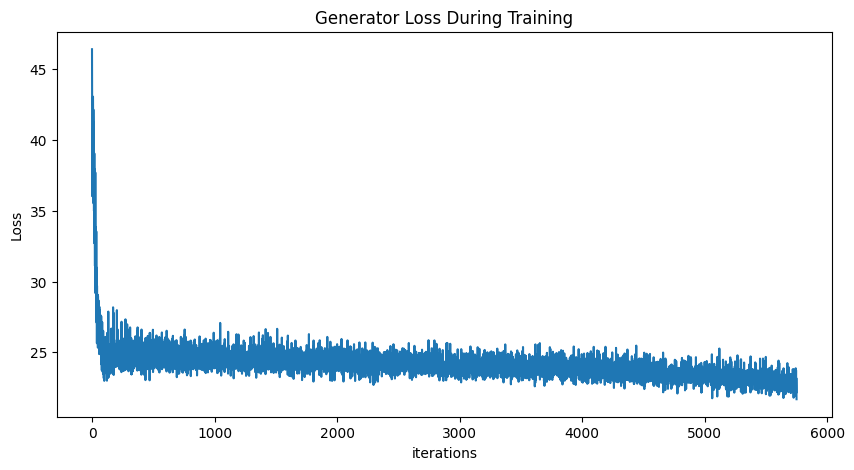

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_GLoss_.png'))

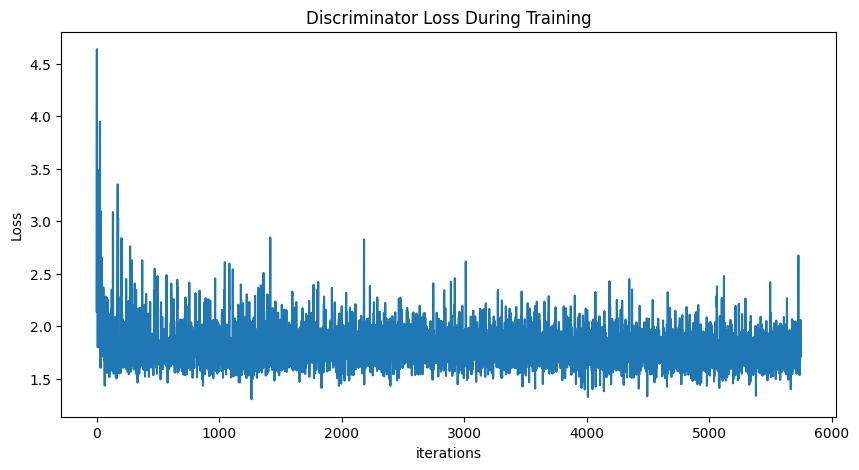

<Figure size 640x480 with 0 Axes>

In [25]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_DLoss.png'))

In [33]:
file_names = os.listdir(output_save_path)
file_names = [name for name in file_names if name.startswith('output_{}_'.format(date))]

# Sort the file names numerically
file_names = sorted(file_names, key=lambda name: int(name.split('_')[3].split('.')[0]))

# Create a list to store the read images
images = []

for file_name in file_names:
    images.append(imageio.imread(os.path.join(output_save_path,file_name)))

imageio.mimsave(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)), images, fps=1)

NameError: name 'date' is not defined

In [34]:
# from IPython.display import Image

# # Load the GIF
# with open(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)),'rb') as file:
#     display(Image(file.read()))

NameError: name 'date' is not defined

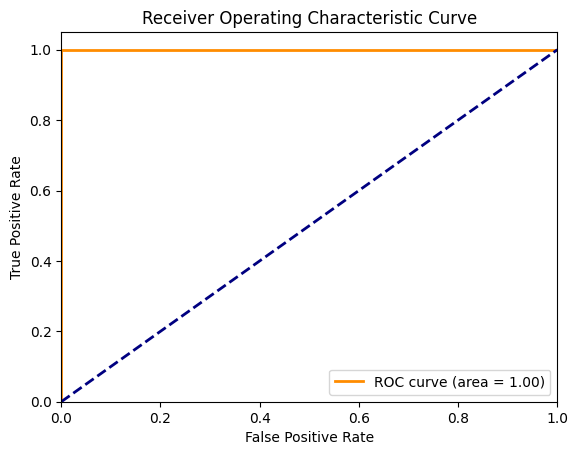

<Figure size 640x480 with 0 Axes>

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Create binary labels for the losses (1 for generator, 0 for discriminator)
y_true = np.concatenate([np.ones(len(G_losses)), np.zeros(len(D_losses))])

# Concatenate the losses for the ROC curve
y_scores = np.concatenate([G_losses, D_losses])

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()
plt.savefig(os.path.join(output_save_path, 'ROC_Curve.png'))